# JPEG Compression Analysis

Image compression has been around practically since images were first stored in digital mediums. As digital imaging technologies advanced, the volume of data continued to compete with available storage. This resulted in an ever-present need for methods to reduce the size of images while retaining key features. Utilizing the knowledge of human light sensitivity, compression techniques such as the JPEG standard have allowed images to maintain perceived clarity while requiring only a fraction of the storage space. An overview of the JPEG compression process flow can be described by the figure below.

<br />

![flowchart](./images/JPEG_flowchart.png)

<br />

This notebook aims to create and analyze a simple implementation of the compression pipeline. Characteristics of importance are computing efficiency and compression ratio.

## Converting RGB to YCbCr Format

### Color Space Conversion

The first step in compressing image data from a lossless format such as PNG requires converting the colorspace of the data. PNG data is usually arranged in standard RGB format. In this format, there are three channels that control the red, green, and blue values directly. The desired format, Y'CbCr, instead separates the brightness from the color. The **Y'** channel represents the pixel brightness, and the **Cb**/**Cr** channels represent the ratio of red-to-green and blue-to-green, respectively.

The conversion from sRGB to YCbCr is standardized according to the JPEG File Interchange Format. According to the ITU-R BT.601 standard (and adjusting for full luminance range), the digital **Y'**, **Cb**, and **Cr** components can be estimated as follows

$$
D_{Y'} \approx \text{INT}\left[\frac{\text{INT}[0.299 \cdot 2^{m}]}{2^{m}}D_{R} + \frac{\text{INT}[0.587 \cdot 2^{m}]}{2^{m}}D_{G} + \frac{\text{INT}[0.114 \cdot 2^{m}]}{2^{m}}D_{B}\right]
$$
$$
D_{Cb} \approx \text{INT}\left[\frac{\text{INT}\left[-\frac{0.299}{1.772} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{R} + \frac{\text{INT}\left[-\frac{0.587}{1.772} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{G} + \frac{\text{INT}\left[\frac{0.886}{1.772} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{B} + 2^{n-1}\right]
$$
$$
D_{Cr} \approx \text{INT}\left[\frac{\text{INT}\left[\frac{0.701}{1.402} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{R} + \frac{\text{INT}\left[-\frac{0.587}{1.402} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{G} + \frac{\text{INT}\left[-\frac{0.114}{1.402} \cdot \frac{224}{219} \cdot 2^{m}\right]}{2^{m}}D_{B} + 2^{n-1}\right]
$$

where $m$ is the bit-length of the integer coefficients and $n$ is the bit-depth of the image data. As $m$ increases, the equation converges on the actual value of each component.

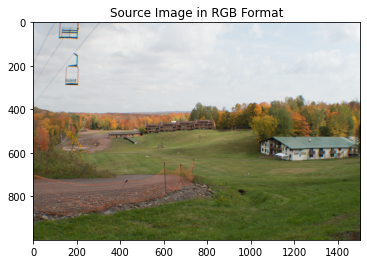

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

im = cv2.cvtColor(cv2.imread("./images/Sample_Photo.png"), cv2.COLOR_BGR2RGB)
assert im.shape[2] == 3, "Wrong number of image channels"

plt.imshow(im)
plt.title("Source Image in RGB Format")
plt.show()

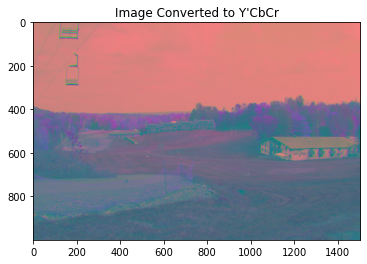

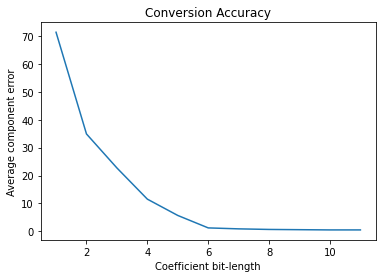

In [38]:
def convertYCbCr(inputImage, m = 1):
    """Convert RGB image to Y'CbCr format

    Parameters
    ----------
    inputImage : ndarray
        3-dimensional RGB input image.
    m : int
        Bit-length of the conversion coefficients. If zero, calculate Y'CbCr values as floats.

    Returns
    -------
    ndarray
        Array of same dimensions as inputImage with Y'CbCr image data. If m is zero, this is
        an array of type float, else it is an array of type uint8

    """
    scale = int(2**m)
    coeffY_R = 0.299 * scale
    coeffY_G = 0.587 * scale
    coeffY_B = 0.114 * scale
    coeffCb_R = (-0.299/1.772) * (224/219) * scale
    coeffCb_G = (-0.587/1.772) * (224/219) * scale
    coeffCb_B = (0.886/1.772) * (224/219) * scale
    coeffCr_R = (0.701/1.402) * (224/219) * scale
    coeffCr_G = (-0.587/1.402) * (224/219) * scale
    coeffCr_B = (-0.114/1.402) * (224/219) * scale
    
    convMat = np.array([[coeffY_R,  coeffY_G,  coeffY_B ],
                        [coeffCb_R, coeffCb_G, coeffCb_B],
                        [coeffCr_R, coeffCr_G, coeffCr_B]])
    
    if m != 0:
        convMat = convMat.astype(int)
    
    # Multiply RGB values by Coefficients
    tmpIm = np.einsum('ijk,hk->ijh', inputImage, convMat)
    if m == 0:
        return np.add(tmpIm, np.array([0, 128, 128]))
    else:
        # Divide by 2^m
        np.right_shift(tmpIm, m, out=tmpIm)
        # Add chroma offsets
        return np.add(tmpIm, np.array([0, 128, 128])).astype(np.uint8)
        
# Reference Y'CbCr image
colorCvtIm = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,[0,2,1]]

plt.imshow(colorCvtIm)
plt.title("Image Converted to Y'CbCr")
plt.show()

# Compute average difference from reference image across coefficient bit-lengths
diffAvg = []
floatIm = convertYCbCr(im, 0)
for m in range(1,12):
    convIm = convertYCbCr(im, m)
    diffAvg.append(np.divide(np.sum(np.abs(np.subtract(floatIm, convIm))), im.size))
    
plt.plot(range(1,12), diffAvg)
plt.title("Conversion Accuracy")
plt.xlabel("Coefficient bit-length")
plt.ylabel("Average component error")
plt.show()

### Chroma Subsampling